# Experiments with GalSim and SExtractor

This notebook shows how to reproduce the experiments in *Approximate Inference for Constructing Astronomical Catalogs from Images* using the [Celeste.jl](https://github.com/jeff-regier/Celeste.jl) package and Julia 0.6.4. To install Celeste, run
```
Pkg.update()
Pkg.add("Celeste")
```

In [1]:
Pkg.status("Celeste")

 - Celeste                       0.4.0+             reproducibility


In [2]:
import Celeste: AccuracyBenchmark, SDSSIO, Synthetic, ParallelRun
using DataFrames
import PyPlot

INFO: Recompiling stale cache file /home/jeff/.julia/lib/v0.6/Celeste.ji for module Celeste.


## 1. Load a catalog

In [4]:
coadd_catalog = AccuracyBenchmark.load_coadd_catalog(AccuracyBenchmark.COADD_CATALOG_FITS)

# filter the coadd catalog -- these columns can't be missing
no_na_cols = :flux_r_nmgy, :color_ug, :color_gr, :color_ri, :color_iz
for col in no_na_cols
    coadd_catalog = coadd_catalog[.!ismissing.(coadd_catalog[col]), :]
end

head(coadd_catalog)

,objid,ra,dec,is_star,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg
1,8647474692482203784,0.536969,0.572232,false,4.20126,1.18763,0.664524,0.941524,-0.0294029,0.658111,0.204593,2.10751,5.16219
2,8647474692482203814,0.543336,0.460541,true,19.3121,2.29263,1.25516,0.825686,0.475343,missing,missing,missing,missing
3,8647474692482138371,0.452067,0.597554,false,13.5317,2.40159,1.45971,0.433763,0.481071,0.983442,0.622878,2.21404,133.298
4,8647474692482138403,0.461833,0.563745,false,1.89322,0.159879,1.63116,0.732745,0.575775,0.906633,0.0653559,0.205927,62.7757
5,8647474692482204160,0.515754,0.517092,true,1.71441,0.944377,0.34063,0.147833,0.0732357,missing,missing,missing,missing
6,8647474692482204190,0.520442,0.598824,true,4.15835,1.00537,0.292471,0.100794,0.0374307,missing,missing,missing,missing


## 2. Load image set

In [5]:
import CSV
CSV.write("coadd.csv", coadd_catalog)
run(`python galsim_field.py coadd.csv galsim_image_set.fits`);

  Image dimensions 2104 W x 1546 H px


Generating 1 test cases
  Generating case celeste_field_test


/home/jeff/miniconda3/lib/python3.6/site-packages/galsim/errors.py:424: GalSimWarning: Automatic n_photons calculation did not end up with positive N. (n_photons = 0.4600606482647096)  No photons will be shot.
  prof = galsim.Convolve((galsim.Exponential(scale_radius=0.00012550022817225316, flux=0.0).shear(galsim.Shear(g1=0.013830327964403475,g2=0.007805050736936103)).shift(-0.03975110004015725,0.042389174559144704) + galsim.DeVaucouleurs(half_light_radius=0.0002106329301993052, flux=1.113201607832232).shear(galsim.Shear(g1=0.013830327964403475,g2=0.007805050736936103)).shift(-0.03975110004015725,0.042389174559144704)), galsim.Gaussian(sigma=0.0002519)).transform(0.0,9090.90909090909,9090.90909090909,0.0).shift(-0.5,-0.5) * 1.21e-08
  flux = 1.113201607832232
  poisson_flux = True
  max_extra_noise = 0.039604240000000006
  g = 1.9525901224547964
  warnings.warn(message, GalSimWarning)
/home/jeff/miniconda3/lib/python3.6/site-packages/galsim/errors.py:424: GalSimWarning: Automatic n_pho

In [6]:
extensions = AccuracyBenchmark.read_fits("galsim_image_set.fits");

In [7]:
galsim_images = AccuracyBenchmark.make_images(extensions);

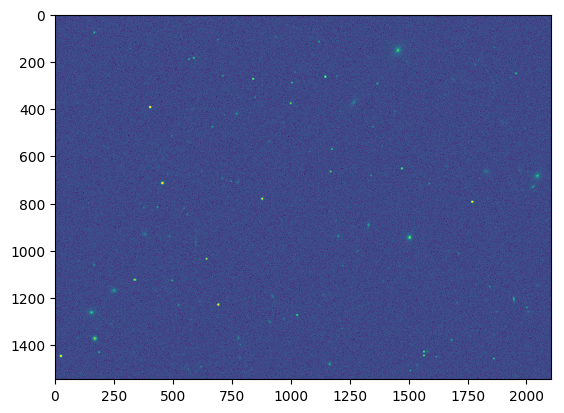

In [8]:
plot_data = AccuracyBenchmark.plot_image(galsim_images[3]);
PyPlot.imshow(plot_data)

## 3. Run source extractor

In [20]:
sep_results = Celeste.detect_sources(galsim_images)[1]

444-element Array{Celeste.Model.CatalogEntry,1}:
 Celeste.Model.CatalogEntry([0.448235, 0.425769], false, [0.793424, 22.4973, 66.0512, 103.361, 135.757], [0.793424, 22.4973, 66.0512, 103.361, 135.757], 0.5, 0.96917, -0.30506, 2.75002)
 Celeste.Model.CatalogEntry([0.452568, 0.530202], false, [11.2669, 29.3412, 38.3376, 41.0336, 34.3786], [11.2669, 29.3412, 38.3376, 41.0336, 34.3786], 0.5, 0.967209, -1.18018, 2.68514) 
 Celeste.Model.CatalogEntry([0.453387, 0.615215], false, [1.4999, 0.0, 0.0, 3.37783, 0.0], [1.4999, 0.0, 0.0, 3.37783, 0.0], 0.5, 0.668907, -1.19097, 1.95122)                           
 Celeste.Model.CatalogEntry([0.457033, 0.502624], false, [0.43584, 0.0, 0.0, 12.2238, 0.0], [0.43584, 0.0, 0.0, 12.2238, 0.0], 0.5, 0.63059, 1.35798, 2.65015)                           
 Celeste.Model.CatalogEntry([0.456586, 0.566999], false, [21.2946, 270.37, 644.343, 941.491, 989.329], [21.2946, 270.37, 644.343, 941.491, 989.329], 0.5, 0.782411, -1.05575, 10.3643)   
 Celeste.Model.Catalo

In [19]:
length(sep_results[1])

444

## 4. Run variational inference (VI) on the image set

The next block of code takes about 30 minutes single threaded. To enable more threads, before launching Jupyter, set two environment variables:
```
export OMP_NUM_THREADS=1
export JULIA_NUM_THREADS=4
```
The most optimized VI implementation is on the [kf/sparsefun5](https://github.com/jeff-regier/Celeste.jl/tree/kf/sparsefun5) branch -- not this one.

In [9]:
dummy_box = ParallelRun.BoundingBox(-1000.0, 1000.0, -1000.0, 1000.0)
vi_results = ParallelRun.infer_box(galsim_images, dummy_box; method = :single_vi);

[1]<1> INFO: processing box -1000.0, 1000.0, -1000.0, 1000.0 with 4 threads
[1]<2> INFO: #3 at (0.4533866442830616, 0.6152146961615055): 21.911214882 secs
[1]<4> INFO: #2 at (0.452568301420809, 0.5302020202775): 22.54700039 secs
[1]<1> INFO: #1 at (0.4482351102609742, 0.4257692342023442): 22.865613517 secs
[1]<3> INFO: #4 at (0.45703338010072597, 0.5026242970232593): 22.951519239 secs
[1]<4> INFO: #6 at (0.45831984265831066, 0.41237874554829523): 0.466317671 secs
[1]<4> INFO: #9 at (0.4632287911203781, 0.6030863358694953): 1.616403841 secs
[1]<1> INFO: #7 at (0.4607444078364463, 0.46968006708049165): 2.022037751 secs
[1]<4> INFO: #10 at (0.46354503690381976, 0.5827966883180924): 0.655935305 secs
[1]<3> INFO: #8 at (0.46175646714288443, 0.5711780029578922): 2.5771047 secs
[1]<4> INFO: #12 at (0.4682964489355287, 0.6195760674592476): 0.5086531 secs
[1]<3> INFO: #13 at (0.46844584976231013, 0.48545787709817445): 1.65743898 secs
[1]<1> INFO: #11 at (0.46732615938250593, 0.622028475877002):

## 5. Run MCMC on the image set

TODO

## 6. Score predictions

In [10]:
celeste_catalog = AccuracyBenchmark.celeste_to_df(vi_results)
prediction_dfs = [celeste_catalog,]
scores = AccuracyBenchmark.score_predictions(coadd_catalog, prediction_dfs)

,N,first,field
1,96,0.15625,missed_stars
2,201,0.253731,missed_galaxies
3,297,0.676354,position
4,297,0.16588,flux_r_mag
5,297,0.890743,flux_r_nmgy
6,45,20.9447,gal_angle_deg
7,115,0.382169,gal_frac_dev
8,115,0.248425,gal_axis_ratio
9,115,0.784184,gal_radius_px
10,297,0.537808,color_ug


## 6. Score uncertainty

In [11]:
uncertainty_df = AccuracyBenchmark.get_uncertainty_df(coadd_catalog, celeste_catalog)
scores = AccuracyBenchmark.score_uncertainty(uncertainty_df)

,field,within_half_sd,within_1_sd,within_2_sd,within_3_sd
1,log_flux_r_nmgy,0.20202,0.333333,0.525253,0.643098
2,color_ug,0.316498,0.545455,0.811448,0.892256
3,color_gr,0.272727,0.518519,0.781145,0.895623
4,color_ri,0.239057,0.47138,0.760943,0.882155
5,color_iz,0.326599,0.59596,0.858586,0.93266
